In [1]:
import json
import os

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

## Load Data

In [2]:
# Set Seaborn theme
sns.set_style('whitegrid')

# Location for the local data
path = './transit_vis/data/delay_modeling_datasets'

# Read urban variable shapefiles
street_data = pd.read_csv(f"{path}/Seattle_Streets.csv", low_memory=False)
bike_data = pd.read_csv(f"{path}/Existing_Bike_Facilities.csv", low_memory=False)
flow_data = pd.read_csv(f"{path}/2018_Traffic_Flow_Counts.csv", low_memory=False)
blockface_data = pd.read_csv(f"{path}/Blockface.csv", low_memory=False)

# Read data from summarize_rds
bus_data_all = pd.read_csv(f"{path}/../all_data.csv", chunksize=1000000, low_memory=False)
bus_data_df = pd.concat(bus_data_all)
del bus_data_all

# Read sharedstreets data
ss_data = pd.read_csv(f"{path}/ss_joined.csv", low_memory=False)

# Filter datasets to variables of interest
street_data = street_data[['COMPKEY','ARTDESCRIPT','SPEEDLIMIT','ONEWAY','SEGLENGTH','SURFACEWIDTH','STREETTYPE',
                           'TRANDESCRIPT','SLOPE_PCT']].copy()
bike_data = bike_data[['COMPKEY','EXISTING_FACILITY_TYPE']].copy()
flow_data = flow_data[['COMPKEY','DOWNTOWN','AWDT']].copy()
blockface_data = blockface_data[['SEGKEY','LOAD','ZONE']].copy().groupby('SEGKEY').sum().reset_index()
ss_data = ss_data[['periodAverageCount','type','join_COMPKEY','distance']]

In [3]:
# AWDT data has multiple compkeys per line comma separated
flow_data = flow_data.dropna()
ck = []
downtown = []
awdt = []
for i in range(0,len(flow_data)):
    keys = flow_data.iloc[i,0].split(',')
    for key in keys:
        ck.append(int(key))
        downtown.append(flow_data.iloc[i,1])
        awdt.append(flow_data.iloc[i,2])
flow_data = pd.DataFrame([ck,downtown,awdt])
flow_data = flow_data.transpose()
flow_data.columns = ['COMPKEY','DOWNTOWN','AWDT']

# AWDT also is recorded as strings
flow_data['AWDT'] = pd.to_numeric(flow_data['AWDT'], errors='coerce')
flow_data['COMPKEY'] = pd.to_numeric(flow_data['COMPKEY'], errors='coerce')
flow_data['COMPKEY'] = flow_data['COMPKEY'].astype('int')
flow_data['AWDT'] = flow_data['AWDT'].astype('int')

# For some reason there is a 'B' value for downtown - meaning not documented in metadata
flow_data = flow_data[flow_data['DOWNTOWN']!='B'].copy()

In [4]:
# Bus data needs to be aggregated by compkey and median/95th pct calculated for each segment
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pct_%s' % n
    return percentile_

bus_data = bus_data_df.groupby(['seg_compkey']).agg(['median', 'var', 'count', percentile(95)]).reset_index()
bus_data = bus_data.loc[bus_data[('seg_route_id', 'count')] > 1]
x = bus_data[('seg_compkey')].values
y = bus_data[('speed_m_s')][['median','pct_95']].iloc[:,0].values
z = bus_data[('speed_m_s')][['median','pct_95']].iloc[:,1].values
bus_data = pd.DataFrame([x,y,z]).transpose()
bus_data.columns = ['seg_compkey','median','pct_95']
bus_data['performance'] = bus_data['median'] / bus_data['pct_95']

In [5]:
# Sharedstreets data needs to be aggregated by compkey and pickups/dropoffs added together/averaged
pickups = ss_data[ss_data['type']=='pickup'].groupby(['join_COMPKEY']).sum()
dropoffs = ss_data[ss_data['type']=='dropoff'].groupby(['join_COMPKEY']).sum()
ss_data = pd.merge(pickups, dropoffs, on='join_COMPKEY')
ss_data['total_hourly_PUDO'] = ss_data['periodAverageCount_x'] + ss_data['periodAverageCount_y']
ss_data = ss_data[['total_hourly_PUDO']].reset_index()

In [6]:
# Print length (# of compkeys) in each dataset to get idea of how many streets have full data
print(len(street_data))
print(len(bike_data))
print(len(flow_data))
print(len(blockface_data))
print(len(bus_data))
print(len(ss_data))

23806
3372
6078
23839
12190
8450


In [7]:
# Merge all datasets on Compkey
model_data = pd.merge(street_data, bike_data.dropna(), how='left', on='COMPKEY')
model_data = pd.merge(model_data, flow_data, how='left', on='COMPKEY')
model_data = pd.merge(model_data, blockface_data, how='left', left_on='COMPKEY', right_on='SEGKEY')
model_data = pd.merge(model_data, bus_data, how='left', left_on='COMPKEY', right_on='seg_compkey')

# Add case where there is no bike facility
model_data.loc[pd.isna(model_data['EXISTING_FACILITY_TYPE']), 'EXISTING_FACILITY_TYPE'] = 'No_Facility'

# Create separate dataset that includes the sharedstreets data
model_data_w_ss = pd.merge(model_data, ss_data, how='left', sort=True, left_on='COMPKEY', right_on='join_COMPKEY')
model_data_w_ss = model_data_w_ss.dropna()

In [8]:
# Show how many NA values per column (places where data not available)
# Note: AWDT is not available for many streets, and bus data is only available for streets in the bus network
# There should be about 4000 streets in the bus network
# About 200 streets are lost due to incomplete AWDT data
# About 1600 streets are lost due to incomplete SS data
print(model_data.isnull().sum(axis=0))

# Remove na rows
print()
print(len(model_data))
model_data = model_data.dropna()
print(len(model_data))

COMPKEY                       0
ARTDESCRIPT                   6
SPEEDLIMIT                    6
ONEWAY                       10
SEGLENGTH                     6
SURFACEWIDTH                  8
STREETTYPE                  790
TRANDESCRIPT                188
SLOPE_PCT                    18
EXISTING_FACILITY_TYPE        0
DOWNTOWN                  17729
AWDT                      17729
SEGKEY                        7
LOAD                          7
ZONE                          7
seg_compkey               18047
median                    18047
pct_95                    18047
performance               18047
dtype: int64

23813
3314


In [9]:
model_data

,COMPKEY,ARTDESCRIPT,SPEEDLIMIT,ONEWAY,SEGLENGTH,SURFACEWIDTH,STREETTYPE,TRANDESCRIPT,SLOPE_PCT,EXISTING_FACILITY_TYPE,DOWNTOWN,AWDT,SEGKEY,LOAD,ZONE,seg_compkey,median,pct_95,performance
21,1296,Minor Arterial,25.0,N,323.0,42.0,Urban Center Connector,MAJOR TRANSIT ROUTE,4.0,"In Street, Minor Separation",N,13771.0,1296.0,0.0,0.0,1296.0,13.0,15.80,0.822785
22,1299,Minor Arterial,25.0,N,417.0,42.0,Urban Center Connector,MAJOR TRANSIT ROUTE,6.0,"In Street, Minor Separation",N,18147.0,1299.0,0.0,2.0,1299.0,9.0,20.00,0.450000
26,1364,Collector Arterial,25.0,N,150.0,30.0,Neighborhood Corridor,MINOR TRANSIT ROUTE,3.0,No_Facility,N,2000.0,1364.0,0.0,0.0,1364.0,4.0,11.55,0.346320
30,1407,Principal Arterial,25.0,Y,540.0,39.0,Urban Village Main,MAJOR TRANSIT ROUTE,5.0,"In Street, Minor Separation",N,10000.0,1407.0,1.0,1.0,1407.0,5.0,15.40,0.324675
43,1591,Principal Arterial,25.0,Y,178.0,28.0,Urban Center Connector,NOT DESIGNATED,1.0,No_Facility,N,3982.0,1591.0,0.0,0.0,1591.0,2.0,2.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23797,11828,Collector Arterial,25.0,N,662.0,40.0,Urban Village Neighborhood,MINOR TRANSIT ROUTE,4.0,No_Facility,N,11214.0,11828.0,0.0,0.0,11828.0,7.0,23.65,0.295983
23800,2341,Minor Arterial,25.0,N,653.0,44.0,Neighborhood Corridor,MINOR TRANSIT ROUTE,4.0,Sharrow,N,5695.0,2341.0,0.0,0.0,2341.0,11.0,21.00,0.523810
23803,22301,Minor Arterial,25.0,N,236.0,42.0,Urban Village Neighborhood,MINOR TRANSIT ROUTE,6.0,No_Facility,N,6285.0,22301.0,0.0,0.0,22301.0,9.0,21.00,0.428571
23807,21459,Collector Arterial,25.0,N,323.0,50.0,Urban Village Neighborhood,MINOR TRANSIT ROUTE,2.0,No_Facility,N,2398.0,21459.0,0.0,0.0,21459.0,3.0,18.00,0.166667


In [10]:
model_data.to_csv('joined_4.csv')

## Linear Regression

In [11]:
z = model_data.drop(labels=['COMPKEY','SEGKEY','seg_compkey'], axis=1)

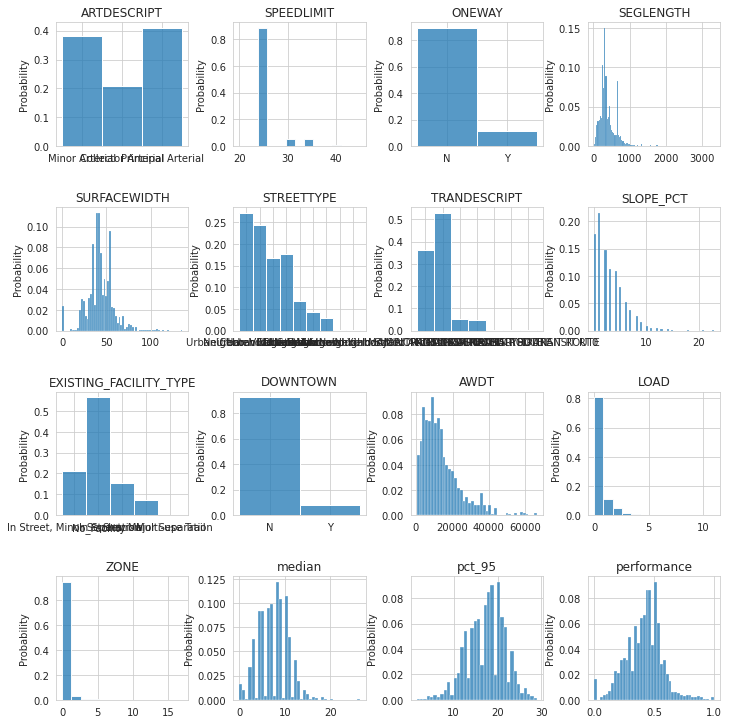

In [12]:
# Check for semi-normal distributions of all variables available in the model data df
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(z.columns):
    sns.histplot(z[col], ax=axes.flat[i], stat='probability')
    axes.flat[i].set_title(col)
    axes.flat[i].set_xlabel(None)

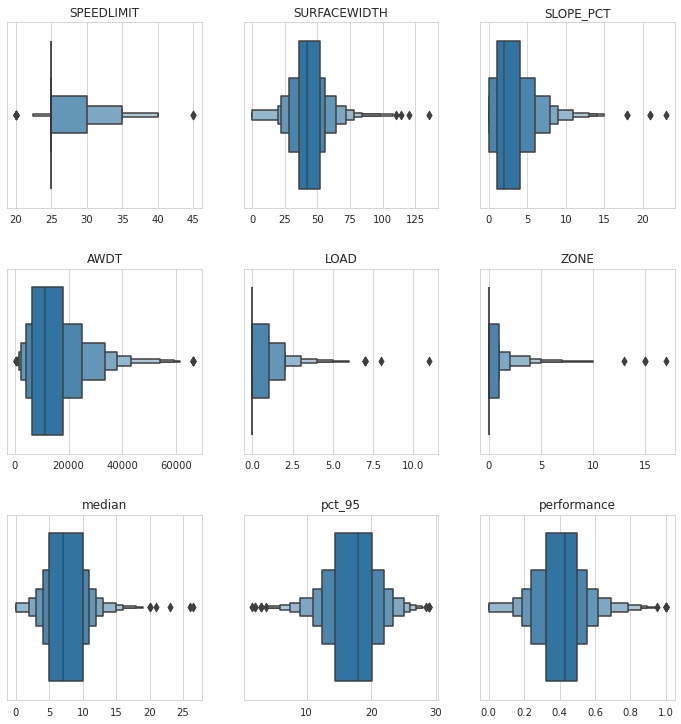

In [14]:
# Check the numerical variables for outliers
model_data_numeric = model_data[['SPEEDLIMIT','SURFACEWIDTH','SLOPE_PCT','AWDT','LOAD','ZONE','median','pct_95','performance']].copy()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(model_data_numeric.columns):
    sns.boxenplot(x=model_data[col], ax=axes.flat[i])
    axes.flat[i].set_title(col)
    axes.flat[i].set_xlabel(None)

                      0
SPEEDLIMIT    60.568401
SURFACEWIDTH   9.936702
SLOPE_PCT      2.178186
AWDT           3.743402
LOAD           1.230290
ZONE           1.108176
median        66.487856
pct_95        72.890698
performance   50.860862


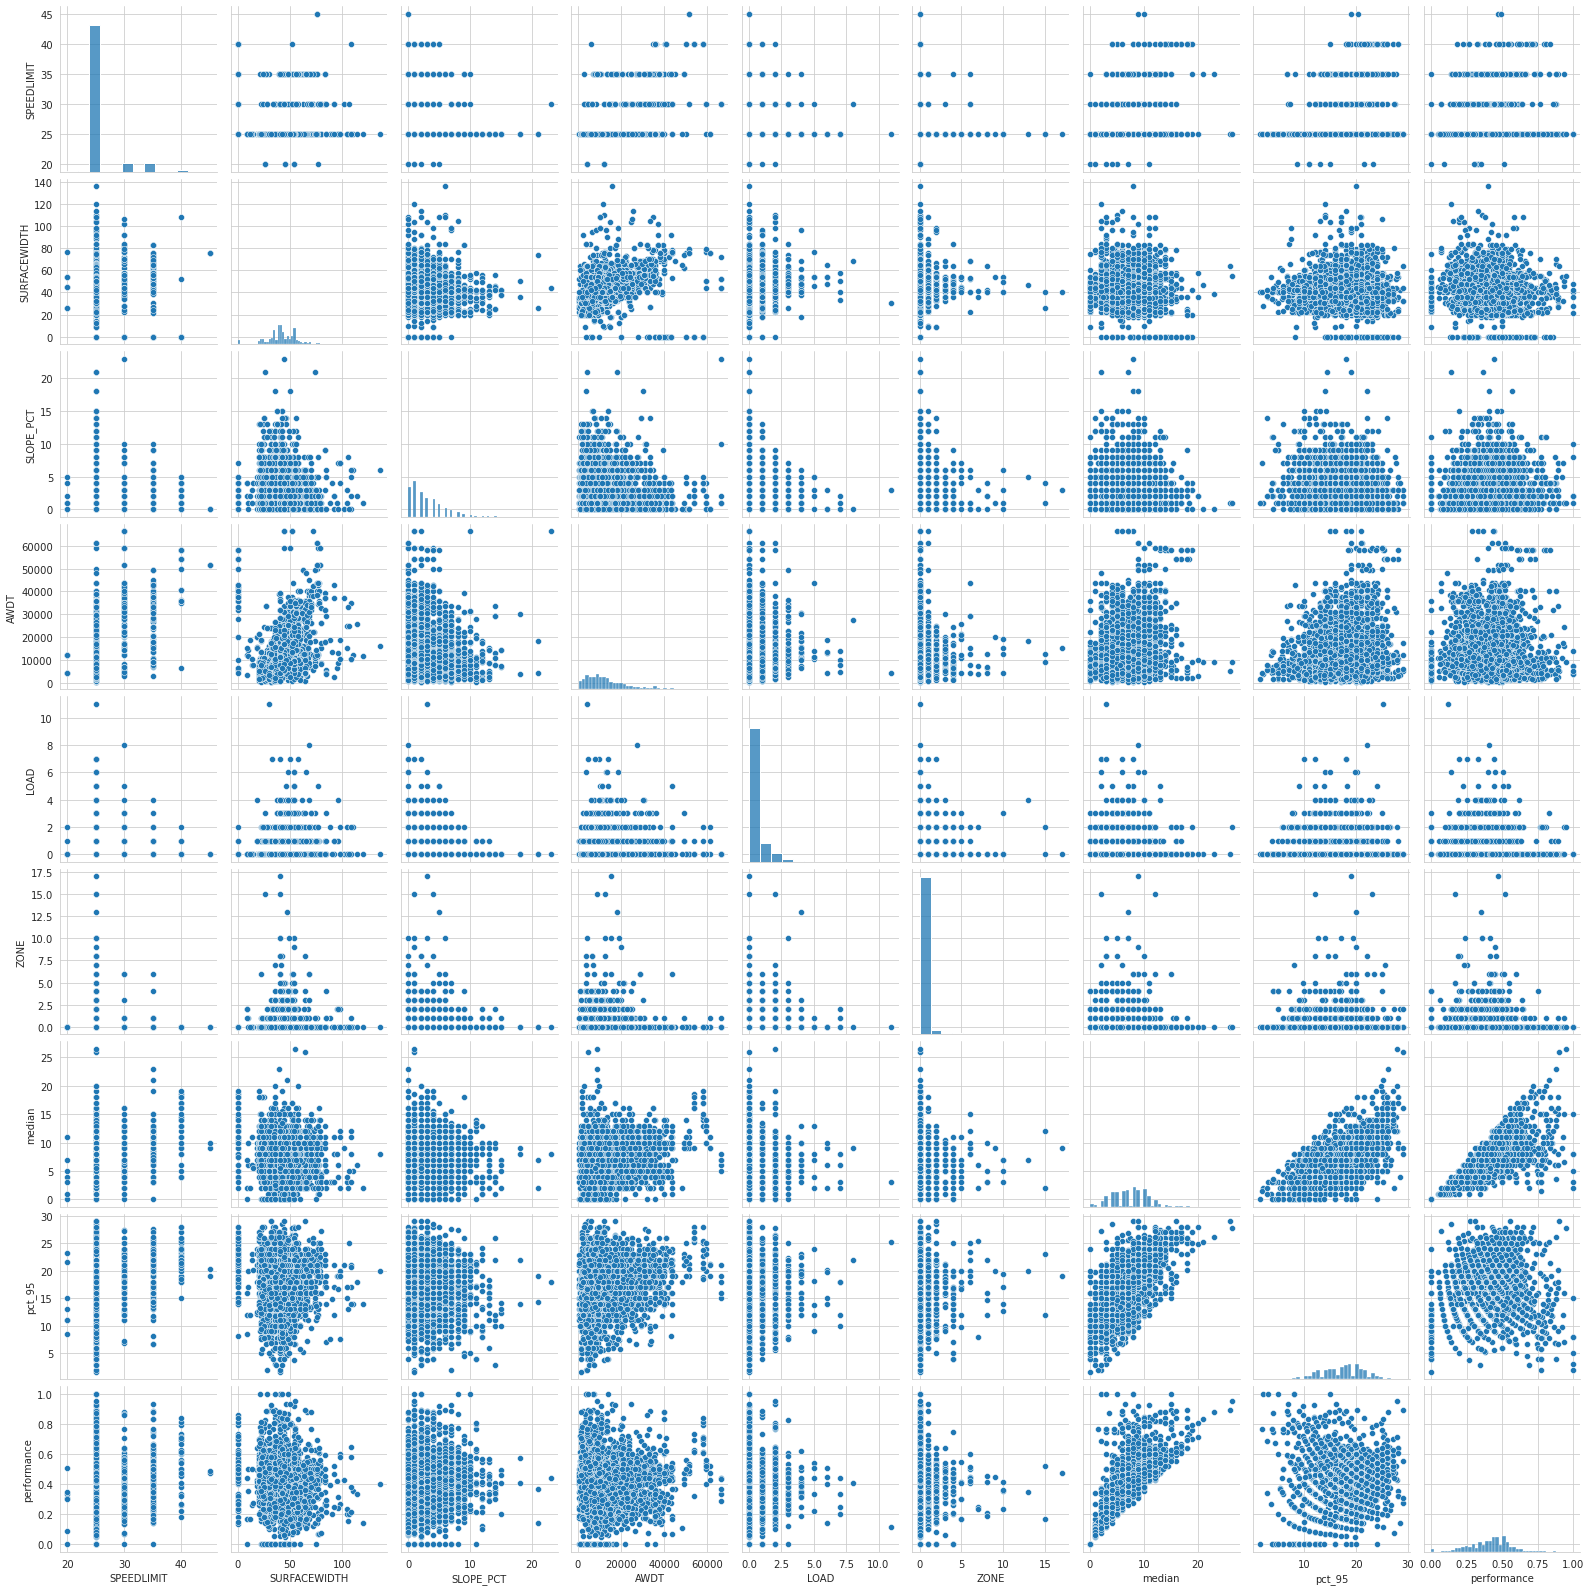

In [15]:
# Check the numerical variables for collinearity
sns.pairplot(model_data_numeric)

# Check the variance inflation factor (1/(1-R^2_i)) where all other variables are regressed against the i variable
# 1 = not correlated.
# Between 1 and 5 = moderately correlated.
# Greater than 5 = highly correlated.
vif_values = []
for i in range(len(model_data_numeric.columns)):
    vif = variance_inflation_factor(model_data_numeric.values, i)
    vif_values.append(vif)
print(pd.DataFrame(vif_values, model_data_numeric.columns))

In [16]:
# All variables
results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  C(ONEWAY, Treatment(reference="N")) + \
                  SEGLENGTH + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  SLOPE_PCT + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE', data=model_data).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     18.08
Date:                Thu, 10 Jun 2021   Prob (F-statistic):           2.93e-82
Time:                        09:55:47   Log-Likelihood:                 1833.0
No. Observations:                3314   AIC:                            -3608.
Df Residuals:                    3285   BIC:                            -3431.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [17]:
# Significant variables only
model_data_sig = model_data.copy()

# Consolidate categories of variables that had one or more significant classes
model_data_sig['TRANDESCRIPT'].replace(
                                to_replace=['MAJOR TRANSIT ROUTE','MINOR TRANSIT ROUTE','PRINCIPAL TRANSIT ROUTE','MINOR RESTRICTED TRANSIT RT','TEMPORARY TRANSIT ROUTE'],
                                value='NON-LOCAL TRANSIT ROUTE',
                                inplace=True)
model_data_sig['EXISTING_FACILITY_TYPE'].replace(
                                to_replace=['Sharrow','In Street, Major Separation','Multi-use Trail'],
                                value='Other Facility Type',
                                inplace=True)

results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE', data=model_data_sig).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     24.84
Date:                Thu, 10 Jun 2021   Prob (F-statistic):           6.96e-82
Time:                        09:55:47   Log-Likelihood:                 1817.4
No. Observations:                3314   AIC:                            -3595.
Df Residuals:                    3294   BIC:                            -3473.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Linear Model w/SharedStreets Data

<AxesSubplot:xlabel='total_hourly_PUDO', ylabel='Probability'>

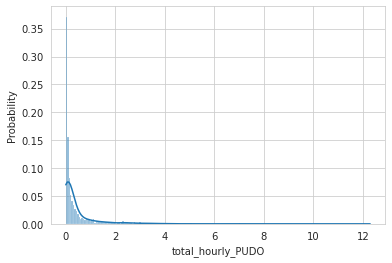

In [18]:
sns.histplot(model_data_w_ss['total_hourly_PUDO'], stat='probability', kde=True)

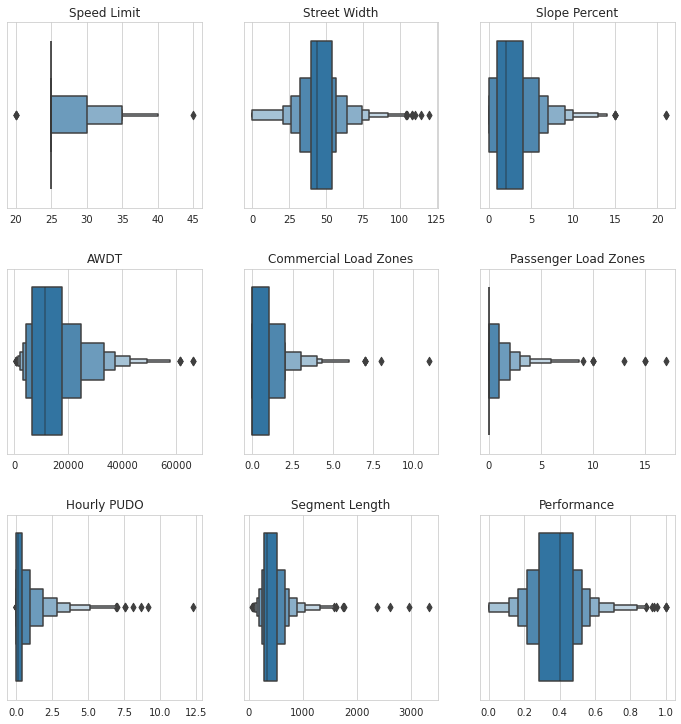

In [35]:
# Check the numerical variables for outliers
model_data_numeric = model_data_w_ss[['SPEEDLIMIT','SURFACEWIDTH','SLOPE_PCT','AWDT','LOAD','ZONE','total_hourly_PUDO','SEGLENGTH','performance']].copy()
names = ['Speed Limit','Street Width','Slope Percent','AWDT','Commercial Load Zones','Passenger Load Zones','Hourly PUDO','Segment Length','Performance']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(model_data_numeric.columns):
    sns.boxenplot(x=model_data_w_ss[col], ax=axes.flat[i])
    axes.flat[i].set_title(names[i])
    axes.flat[i].set_xlabel(None)

# sns.boxenplot(x=model_data_w_ss['total_hourly_PUDO'])

                               0
Hourly PUDO             1.404185
Speed Limit            14.166680
Street Width           11.094787
Slope Percent           2.161853
AWDT                    3.612186
Commercial Load Zones   1.398570
Passenger Load Zones    1.226660


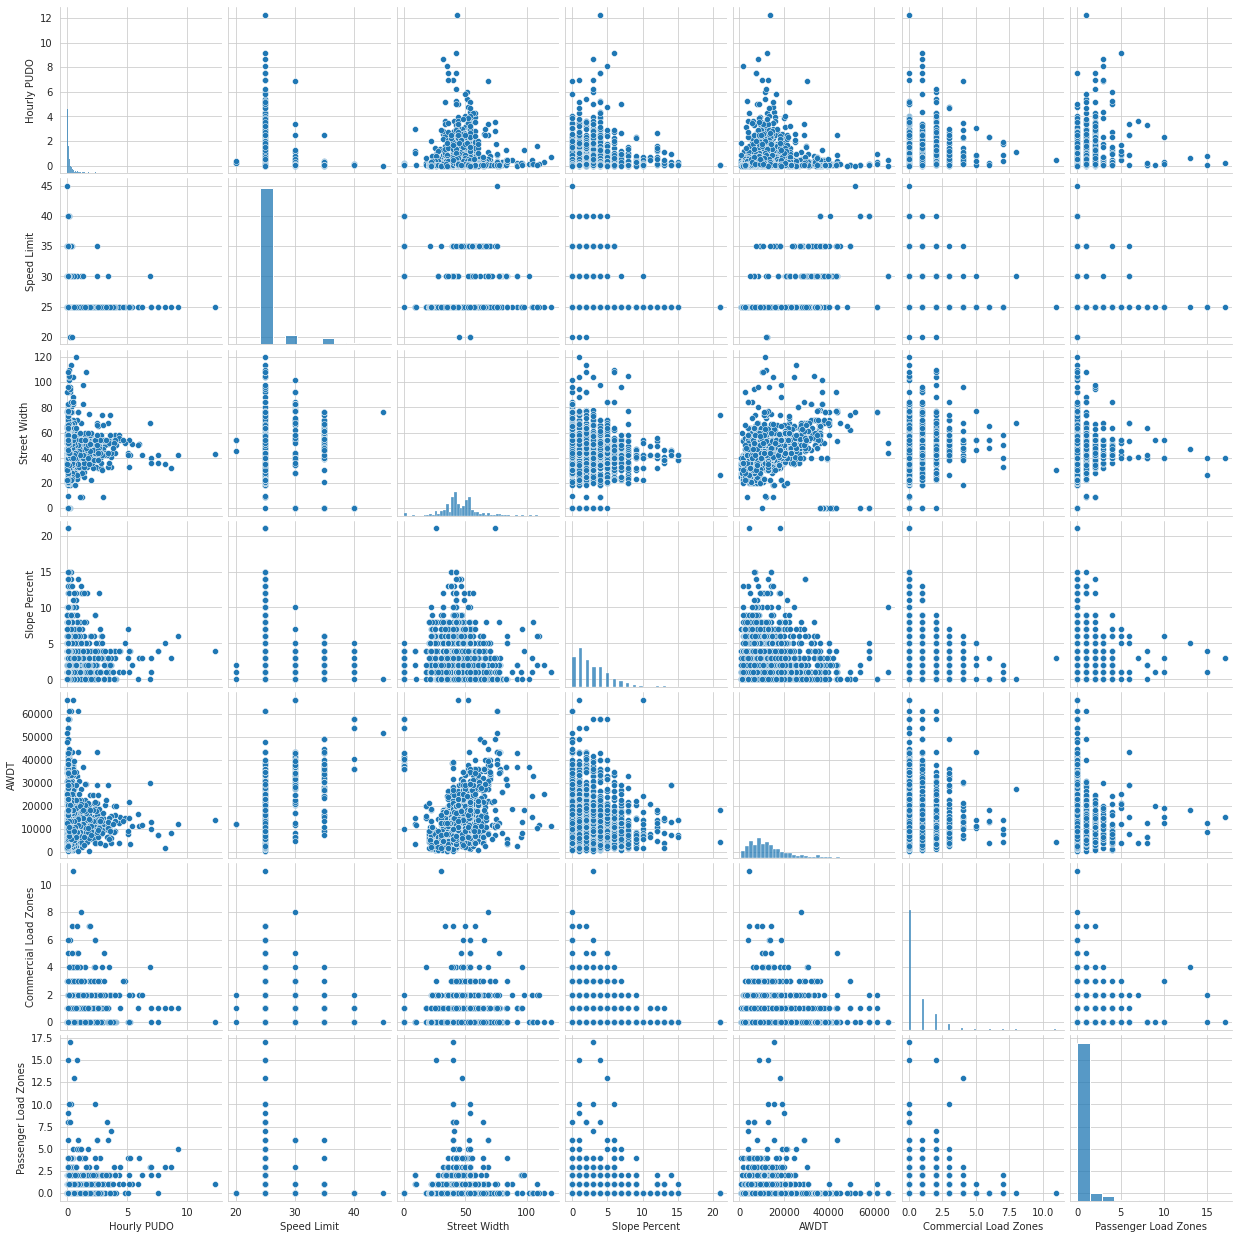

In [37]:
# Check the numerical variables for outliers
model_data_numeric_w_ss = model_data_w_ss[['total_hourly_PUDO','SPEEDLIMIT','SURFACEWIDTH','SLOPE_PCT','AWDT','LOAD','ZONE']].copy()
model_data_numeric_w_ss.columns = ['Hourly PUDO','Speed Limit','Street Width','Slope Percent','AWDT','Commercial Load Zones','Passenger Load Zones']
# Check the numerical variables for collinearity
sns.pairplot(model_data_numeric_w_ss)

# Check the variance inflation factor (1/(1-R^2_i)) where all other variables are regressed against the i variable
# 1 = not correlated.
# Between 1 and 5 = moderately correlated.
# Greater than 5 = highly correlated.
vif_values = []
for i in range(len(model_data_numeric_w_ss.columns)):
    vif = variance_inflation_factor(model_data_numeric_w_ss.values, i)
    vif_values.append(vif)
print(pd.DataFrame(vif_values, model_data_numeric_w_ss.columns))

In [38]:
# All variables
results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  C(ONEWAY, Treatment(reference="N")) + \
                  SEGLENGTH + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  SLOPE_PCT + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE + \
                  total_hourly_PUDO', data=model_data_w_ss).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     10.65
Date:                Thu, 10 Jun 2021   Prob (F-statistic):           4.72e-43
Time:                        10:06:17   Log-Likelihood:                 1109.2
No. Observations:                1878   AIC:                            -2160.
Df Residuals:                    1849   BIC:                            -2000.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Other Model Tests

In [22]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
# Create arrays for x/y data
data_y = model_data_w_ss[['performance']].values
data_x = model_data_w_ss.drop(['COMPKEY','seg_compkey','join_COMPKEY','SEGKEY','median','pct_95','performance'], axis=1)

# OHE the categorical variables
cat_vars = data_x.select_dtypes('object').columns.values
data_x = pd.get_dummies(data_x, columns=cat_vars, prefix='', prefix_sep='')

#### Lasso

In [24]:
# define model
model = Lasso(alpha=i)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, data_x, data_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.113 (0.006)


#### Random Forest

In [25]:
model = RandomForestRegressor().fit(data_x, data_y.flatten())
pred_y = model.predict(data_x)
mse = mean_squared_error(data_y, pred_y)
print(mse)

0.002528294436236962


#### Neural Net

In [26]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 200
HIDDEN_DIM = 64
CAT_IDX = 8

# Separate train/validation, and test data
train_x = data_x.values[:1000,:]
train_y = data_y[:1000,:]
test_x = data_x.values[1000:,:]
test_y = data_y[1000:,:]

In [27]:
# Scale continuous variables separately
scaler_train = skpre.StandardScaler()
scaler_test = skpre.StandardScaler()
train_x[:,:CAT_IDX] = scaler_train.fit_transform(train_x[:,:CAT_IDX])
test_x[:,:CAT_IDX] = scaler_test.fit_transform(test_x[:,:CAT_IDX])

In [28]:
inputs = keras.Input(shape=(train_x.shape[1],))
x = layers.Dense(HIDDEN_DIM, activation="sigmoid")(inputs)
y = layers.Dense(HIDDEN_DIM, activation="sigmoid")(x)
outputs = layers.Dense(train_y.shape[1], activation="sigmoid")(y)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 35)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train
model.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")
history = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0609 - val_loss: 0.0243
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0188
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0184
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0182
Epoch 8/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 9/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0180
Epoch 10/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0179
Epoch 11

13/13 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0183
Epoch 84/200
13/13 [==============================] - 0s 4ms/step - loss: 0.0172 - val_loss: 0.0179
Epoch 85/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 86/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0180
Epoch 87/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 88/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 89/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 90/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 91/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0179
Epoch 92/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0180
Epoch 93/200


13/13 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0212
Epoch 165/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0208
Epoch 166/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0199
Epoch 167/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0231
Epoch 168/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0201
Epoch 169/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0202
Epoch 170/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.0221
Epoch 171/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0216
Epoch 172/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0201
Epoch 173/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0207
Epoc

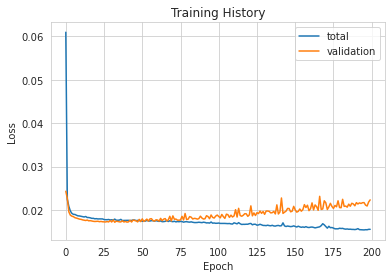

In [30]:
# Plot model loss/training progress
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","validation"], loc="upper right")
plt.show()

In [31]:
results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)
prediction = model.predict(test_x[:10])
actual = test_y[:10]
pd.DataFrame(data=[prediction.flatten(), actual.flatten()]).transpose()

14/14 [==============================] - 0s 1ms/step - loss: 0.0232


,0,1
0,0.361635,0.000000
1,0.327329,0.256410
2,0.326127,0.000000
3,0.321691,0.210526
4,0.299697,0.167015
5,0.376035,0.190024
6,0.442263,0.529412
7,0.419290,0.473684
8,0.403351,0.516796
9,0.407527,0.524781
